
1. Introduce the Problem


The problem I want to solve is automatic dog breed identification. Given a photo of a dog, the goal is to predict its breed from among 120 possible classes. This is a classification problem.

You want to see if the model can correctly identify your own Rottweiler. That’s a motivating example to mention.


Can an algorithm correctly identify a dog’s breed?

Which breeds are most often confused?

How accurate can we get with transfer learning on a relatively small dataset?

## 2. Introduce the Data

The dataset I am using is the **Dog Breed Identification** dataset from Kaggle:  
https://www.kaggle.com/c/dog-breed-identification

This dataset contains images of 120 different dog breeds. The goal is to correctly classify each image into its breed.

**Dataset structure:**
- `labels.csv` → maps each image ID to its breed (two columns: `id`, `breed`).
- `train/` → ~10,000 training images (used for building the model).
- `test/` → ~10,000 test images (unlabeled, used for Kaggle leaderboard submissions, but I will mainly use them for testing inference).

**Features:**
- Raw features are the pixel values of the dog images.
- We will transform these images into tensors and normalize them for use with a deep learning model.
- The **target variable** is the dog's breed (120 possible categories).

## 3. Preprocessing the Data

Before training the model, I needed to preprocess the dataset. The preprocessing steps I followed were:

- **Loading labels.csv** to map each image ID to a breed.
- **Encoding breeds into numbers** because machine learning models require numeric labels.
- **Train/Validation split** (85/15) so I can measure how well the model generalizes.
- **Image transforms**:
  - Resize to 224×224 pixels to match pretrained CNN input.
  - Normalize images using ImageNet mean and standard deviation (because I will use pretrained ImageNet weights).
  - Data augmentation (random crop, flip, color jitter) on training images to help the model generalize better.

These steps ensure the data is in the correct format, balanced between train and validation, and standardized for transfer learning.


In [4]:
# install required moduels 
!pip install numpy pandas matplotlib seaborn scikit-learn pillow torch torchvision torchaudio


  Using cached numpy-2.3.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached scipy-1.16.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached ty

In [2]:
# 3. Preprocessing the Data

import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image   # Open imgs

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms  # common img prep

# Path to your data
DATA_DIR = Path("data")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
LABELS_CSV = DATA_DIR / "labels.csv"

# Load labels and inspect them
labels_df = pd.read_csv(LABELS_CSV)
print("Number of images:", len(labels_df))
print("Number of unique breeds:", labels_df['breed'].nunique())

# Encode breeds -> numbers
breeds = sorted(labels_df['breed'].unique())
breed_to_idx = {b: i for i, b in enumerate(breeds)}
idx_to_breed = {i: b for b, i in breed_to_idx.items()}

labels_df['label'] = labels_df['breed'].map(breed_to_idx)

# Train/Validation split train:85% validation:15%
VAL_FRAC = 0.15
val_size = int(len(labels_df) * VAL_FRAC)

np.random.seed(42)
val_idx = np.random.choice(labels_df.index, size=val_size, replace=False)
train_idx = labels_df.index.difference(val_idx)

train_df = labels_df.loc[train_idx].reset_index(drop=True)
val_df = labels_df.loc[val_idx].reset_index(drop=True)

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Image transforms
IMG_SIZE = 224
#random crop, flip, color jitter to help the model generalize by seeing slightly diff imges
#normalize, center pixel value using ImageNet stat (CNN helper)
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset class to connect images on disk with labels in DataFrame
class DogBreedDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / f"{row['id']}.jpg"
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label']
        return image, label

# Datasets
train_ds = DogBreedDataset(train_df, TRAIN_DIR, train_tfms)
val_ds = DogBreedDataset(val_df, TRAIN_DIR, val_tfms)

# Dataloaders
BATCH_SIZE = 32   # splits batches
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

len(train_ds), len(val_ds)


Number of images: 10222
Number of unique breeds: 120
Train samples: 8689, Validation samples: 1533


(8689, 1533)

## 4. Data Understanding & Visualization

I explored the label distribution and visual examples to understand potential challenges.

**What I looked at and why:**
- **Class counts** (bar chart): to see imbalance, which can affect accuracy and suggest weighted loss or augmentation.
- **Top-20 most common breeds**: to focus on likely strong classes.
- **Sample images**: to check image quality/variation (pose, lighting, background).
- **Rottweiler examples**: since I want to test on my own dog, I verified how many Rottweiler images exist and what they look like.

These insights guide my modeling choices in Section 5 (e.g., data augmentation strength, validation design, and choosing transfer learning).


# 4.1 Class distribution
Class counts + plots

Total training images: 8689
Total validation images: 1533
Unique breeds: 120

Top 10 breeds by count:
breed
maltese_dog             103
afghan_hound            101
pomeranian               97
samoyed                  97
bernese_mountain_dog     94
basenji                  94
shih-tzu                 94
scottish_deerhound       94
leonberg                 93
entlebucher              93
Name: count, dtype: int64

Imbalance ratio (max_count / min_count): 1.91


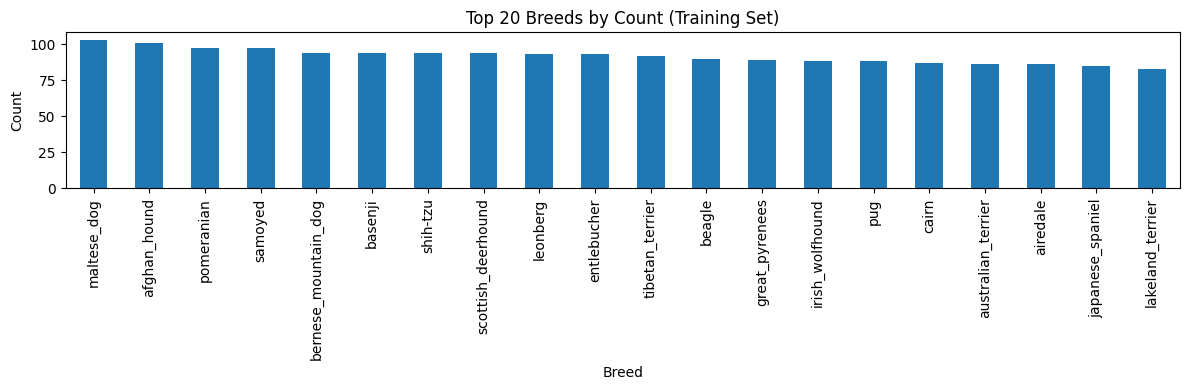

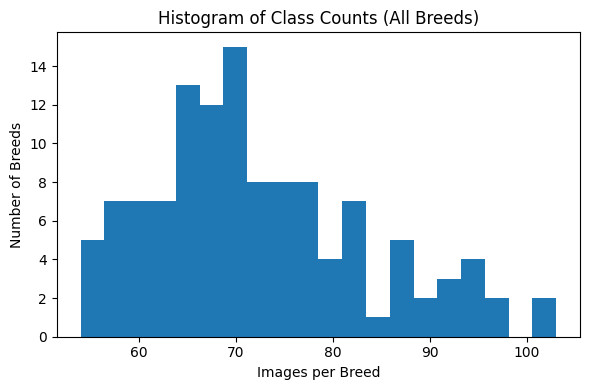

In [3]:
# 4.1) Class distribution
import matplotlib.pyplot as plt
# counts per breed
breed_counts = train_df['breed'].value_counts()

print("Total training images:", len(train_df))
print("Total validation images:", len(val_df))
print("Unique breeds:", train_df['breed'].nunique())

print("\nTop 10 breeds by count:")
print(breed_counts.head(10))

# Imbalance ratio (max/min)
imbalance_ratio = breed_counts.max() / breed_counts.min()
print(f"\nImbalance ratio (max_count / min_count): {imbalance_ratio:.2f}")

# Bar chart: top 20
plt.figure(figsize=(12,4))
breed_counts.head(20).plot(kind='bar')
plt.title("Top 20 Breeds by Count (Training Set)")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histogram of all counts (to see overall spread)
plt.figure(figsize=(6,4))
plt.hist(breed_counts.values, bins=20)
plt.title("Histogram of Class Counts (All Breeds)")
plt.xlabel("Images per Breed")
plt.ylabel("Number of Breeds")
plt.tight_layout()
plt.show()


Show random sample images from training set 

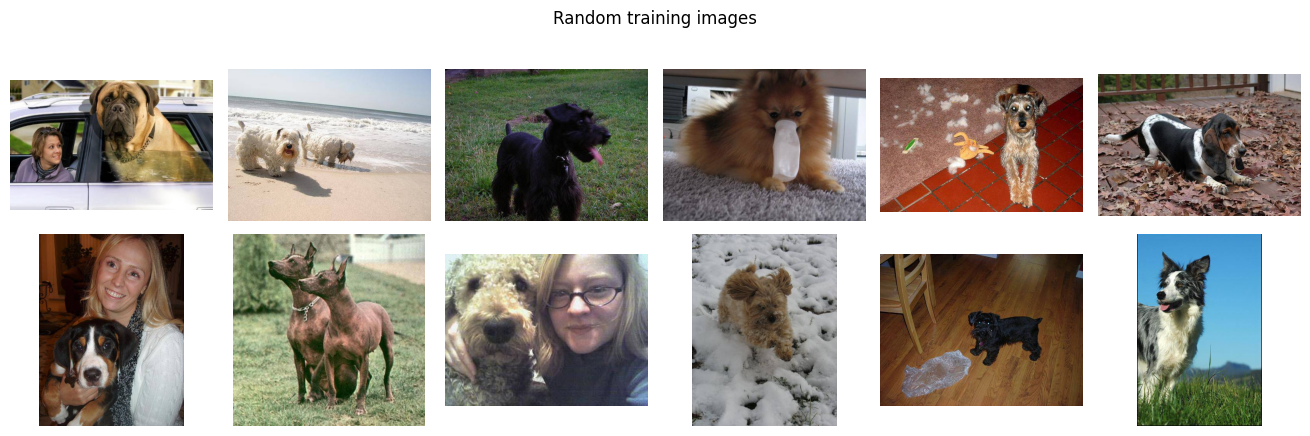

In [4]:
# 4.2) Visual sanity check: random sample images

import math
from PIL import Image

def show_random_images(df, n=12, title="Random training images"):
    ids = df.sample(n=n, random_state=np.random.randint(0, 10_000))['id'].tolist()
    cols = 6
    rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, img_id in enumerate(ids, 1):
        img = Image.open(TRAIN_DIR / f"{img_id}.jpg").convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_images(train_df, n=12)


Rottweiler Focus (counts + examples)

Rottweiler images in TRAIN: 67
Sample IDs: ['11f1e40f11ca1babbcc547c5c98a1a3c', '1bdd7be5d86db9f293136bc94338e667', '1be0f5da239e9c76a8b3693b2ff8c67f', '1f6ae325f91713701c9ae3d8ea6714fd', '23e182419007d6293ae31d6fb4b7076d']


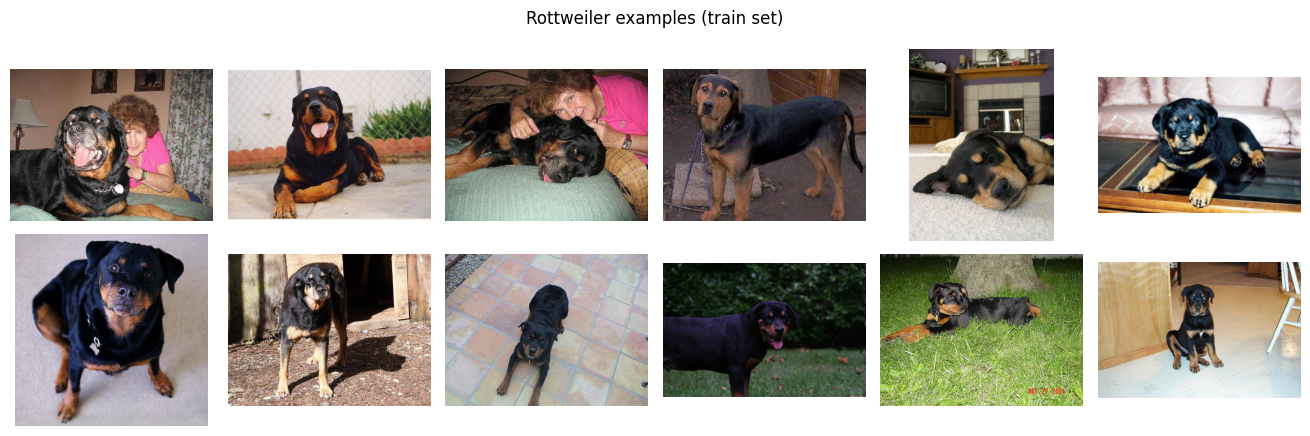

In [4]:
# 4.3) Rottweiler presence and examples

rott_name = "rottweiler"  # Kaggle labels use lowercase with underscores
rott_train = train_df[train_df['breed'] == rott_name]

print(f"Rottweiler images in TRAIN: {len(rott_train)}")
print("Sample IDs:", rott_train['id'].head(5).tolist())

def show_images_by_ids(df_subset, n=12, title="Samples"):
    import math
    ids = df_subset['id'].sample(n=min(n, len(df_subset)), random_state=123).tolist()
    cols = 6
    rows = math.ceil(len(ids)/cols)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, img_id in enumerate(ids, 1):
        img = Image.open(TRAIN_DIR / f"{img_id}.jpg").convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

if len(rott_train) > 0:
    show_images_by_ids(rott_train, n=12, title="Rottweiler examples (train set)")
else:
    print("No Rottweiler images found in train (double-check label spelling).")


## 5. Modeling

Since this is an image classification task, I used a **Convolutional Neural Network (CNN)** via **transfer learning**. 

- **Why CNNs?**  
  CNNs are the standard for images because they detect local features like edges, textures, and shapes. These features build hierarchically into more complex patterns (like a dog’s face or body).

- **Why transfer learning?**  
  Training a CNN from scratch would require millions of images. Instead, I used a **pretrained ResNet-50** (trained on ImageNet). The early layers already know general visual features, and I only retrain the final layers for the 120 dog breeds. This is efficient and reduces overfitting.

- **ResNet-50**:  
  - Pros: good accuracy, widely used, pretrained weights available.  
  - Cons: large model, slower on CPU (though still usable).  
  - Key feature: “skip connections” that allow very deep networks to train without vanishing gradients.

- **Alternative models (not used here but possible):**
  - ResNet-18 (lighter, faster but less accurate).  
  - EfficientNet (more efficient scaling, strong performance, but harder to fine-tune).  

- **Training choices:**  
  - Loss: CrossEntropyLoss (standard for multi-class classification).  
  - Optimizer: AdamW (stable, includes weight decay to reduce overfitting).  
  - Scheduler: ReduceLROnPlateau (lowers learning rate if validation loss stalls).  
  - Early stopping: stop training if validation loss doesn’t improve for a few epochs.


In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Number of classes
num_classes = len(breeds)

# 5.1) Build model
def build_model(name="resnet50", num_classes=num_classes):
    if name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
    elif name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return model

# Initialize model
model = build_model("resnet50", num_classes)

# Device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
model = model.to(DEVICE)

# 5.2) Freeze backbone layers (optional)
for name, param in model.named_parameters():
    if not name.startswith("fc"):   # only train final layer at first
        param.requires_grad = False

# 5.3) Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=3e-4, weight_decay=1e-4)

# 5.4) Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                 factor=0.5, patience=1)


Using device: cuda


## 6. Training

I trained the transfer-learning model with:
- **Loss:** CrossEntropyLoss (multi-class classification).
- **Optimizer:** AdamW (with weight decay to reduce overfitting).
- **Scheduler:** ReduceLROnPlateau (halve LR when validation loss stalls).
- **Early stopping:** stop when validation loss doesn’t improve for `patience` epochs.
- **Checkpoints:** save `checkpoint.pt` every epoch and `best_model.pt` when validation improves.

During each epoch I report training/validation loss and accuracy. After training I plot learning curves.


In [7]:
# use pytorch to unlock GPU processing (took over 4 hrs and never finished on cpu)

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126


Looking in indexes: https://download.pytorch.org/whl/cu126
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB 8.7 MB/s eta 0:05:34
   ---------------------------------------- 0.0/2.9 GB 13.5 MB/s eta 0:03:36
   ---------------------------------------- 0.0/2.9 GB 17.7 MB/s eta 0:02:44
   ---------------------------------------- 0.0/2.9 GB 17.5 MB/s eta 0:02:46
   ---------------------------------------- 0.0/2.9 GB 19.3 MB/s eta 0:02:30
   ---------------------------------------- 0.0/2.9 GB 20.6 MB/s eta 0:02:21
   ---------------------------------------- 0.0/2.9 GB 21.7 MB/s eta 0:02:14
    --------------------------------------- 0.0/2.9 GB 22.5 MB/s eta 0:02:08
    --------------------------------------- 0.0/2.9 GB 23.9 MB/s eta 0:02:01
    --------------------------------------- 0.1/2.9 GB 24.5 MB/s eta 0:01:57
    --------------------------------------- 0.1/2.9 GB 25.9 MB/s eta 0:01:51
    ----------------------

GPU-friendly Tweaks 

In [6]:
import torch
torch.backends.cudnn.benchmark = True   # speed up on fixed-size inputs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


DataLoader 

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64   # try 64 on GPU; reduce to 32 if you OOM
NUM_WORKERS = 4   # or higher if you have CPU cores

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)


test gpu and batch time

C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\345537397.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


Model device: cuda:0


C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\345537397.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):


One forward (batch=64) took 1.578s


C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\345537397.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):


[train    0/136] loss=4.7916
[train   20/136] loss=4.4865
[train   40/136] loss=4.4021
[train   60/136] loss=4.1808
[train   80/136] loss=3.9194
[train  100/136] loss=3.6483
[train  120/136] loss=3.5448
[val     0/24] loss=3.4970
[val    20/24] loss=3.5497
Epoch 01/2 | train 4.0861/0.3237 | val 3.4933/0.6034 | lr=3.00e-04 | 139.4s
[train    0/136] loss=3.2105
[train   20/136] loss=3.2011
[train   40/136] loss=2.9852
[train   60/136] loss=2.8874
[train   80/136] loss=2.6934
[train  100/136] loss=2.6016
[train  120/136] loss=2.5143
[val     0/24] loss=2.6387
[val    20/24] loss=2.7038
Epoch 02/2 | train 2.8767/0.7312 | val 2.6331/0.7352 | lr=3.00e-04 | 57.6s


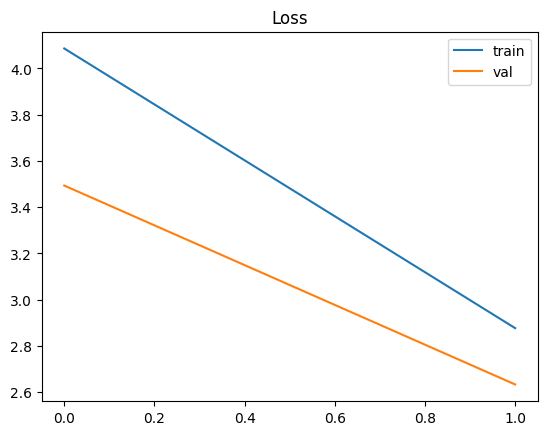

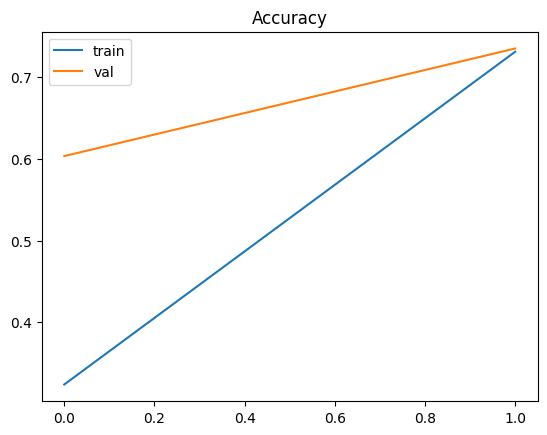

In [8]:
# ==== FAST & SAFE TRAINING BLOCK (Windows + GPU) ====

import time, json, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path

# 1) Rebuild DataLoaders with Windows-safe settings
BATCH_SIZE   = 64        # drop to 32 if you hit CUDA OOM
NUM_WORKERS  = 0         # Windows/Jupyter: avoid multi-proc overhead/hangs
PIN_MEMORY   = False     # start False; can try True later
PERSISTENT   = False

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT
)

# 2) Model, loss, optim, scheduler (on GPU)
num_classes = len(breeds)
model = build_model("resnet50", num_classes).to(DEVICE)

# freeze backbone first pass (speeds up + reduces overfit)
for name, p in model.named_parameters():
    if not name.startswith("fc"):
        p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

# 3) Quick sanity: show devices and one forward speed
print("Model device:", next(model.parameters()).device)
xb, yb = next(iter(train_loader))
xb = xb.to(DEVICE); yb = yb.to(DEVICE)
t0=time.time()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):
    _ = model(xb)
print(f"One forward (batch={xb.size(0)}) took {time.time()-t0:.3f}s")

# 4) Training (short run to verify speed)
EPOCHS = 2          # run 2 first; bump to 8–12 after it looks fast
PATIENCE = 2
OUTPUT_DIR = Path("outputs"); OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val = float("inf"); patience_left = PATIENCE

def run_epoch(loader, train_mode=True, print_every=20):
    if train_mode: model.train()
    else:          model.eval()

    total_loss=0; total_correct=0; total=0
    for bi, (xb, yb) in enumerate(loader):
        xb = xb.to(DEVICE, non_blocking=False); yb = yb.to(DEVICE, non_blocking=False)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        preds = logits.argmax(1)
        total_loss += loss.item() * xb.size(0)
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

        if bi % print_every == 0:
            print(f"[{'train' if train_mode else 'val '} {bi:4d}/{len(loader)}] loss={loss.item():.4f}")

    return total_loss/total, total_correct/total

for epoch in range(1, EPOCHS+1):
    t0=time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader, train_mode=False)
    scheduler.step(val_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train {tr_loss:.4f}/{tr_acc:.4f} | "
          f"val {val_loss:.4f}/{val_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | "
          f"{time.time()-t0:.1f}s")

    torch.save({"model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history,
                "breeds": breeds}, OUTPUT_DIR/"checkpoint.pt")

    if val_loss < best_val - 1e-4:
        best_val = val_loss; patience_left = PATIENCE
        torch.save(model.state_dict(), OUTPUT_DIR/"best_model.pt")
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Early stopping."); break

# 5) Curves
plt.figure(); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); 
plt.title("Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); 
plt.title("Accuracy"); plt.legend(); plt.show()


Full GPU training loop w/ mixed precision     (rewrote above)

C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\1995884575.py:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))
C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\1995884575.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda"), dtype=torch.float16):


[train]    0/136  loss=4.7967
[train]   50/136  loss=4.1792
[train]  100/136  loss=3.7102
[val]    0/24  loss=3.5424
Epoch 01/10 | train_loss=4.1033 acc=0.3122 | val_loss=3.5117 acc=0.5943 | lr=3.00e-04 | 134.9s
[train]    0/136  loss=3.3991
[train]   50/136  loss=3.0510
[train]  100/136  loss=2.7242
[val]    0/24  loss=2.6468
Epoch 02/10 | train_loss=2.8823 acc=0.7291 | val_loss=2.6342 acc=0.7332 | lr=3.00e-04 | 59.0s
[train]    0/136  loss=2.3802
[train]   50/136  loss=2.1441
[train]  100/136  loss=2.0709
[val]    0/24  loss=2.0393
Epoch 03/10 | train_loss=2.0754 acc=0.8115 | val_loss=2.0111 acc=0.7789 | lr=3.00e-04 | 60.9s
[train]    0/136  loss=1.7749
[train]   50/136  loss=1.4536
[train]  100/136  loss=1.5244
[val]    0/24  loss=1.6469
Epoch 04/10 | train_loss=1.5342 acc=0.8563 | val_loss=1.6260 acc=0.7991 | lr=3.00e-04 | 59.3s
[train]    0/136  loss=1.3638
[train]   50/136  loss=1.2229
[train]  100/136  loss=1.0245
[val]    0/24  loss=1.3796
Epoch 05/10 | train_loss=1.1845 acc=0.

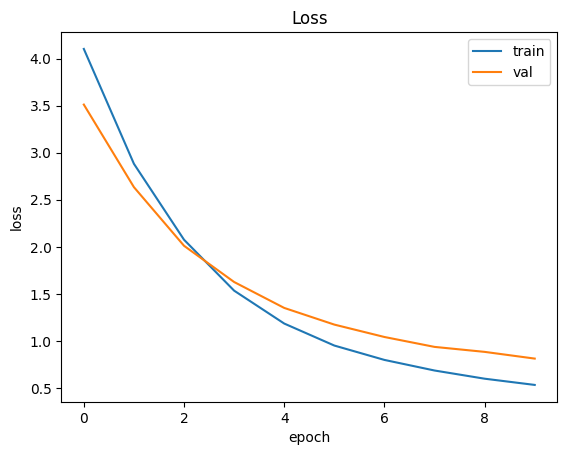

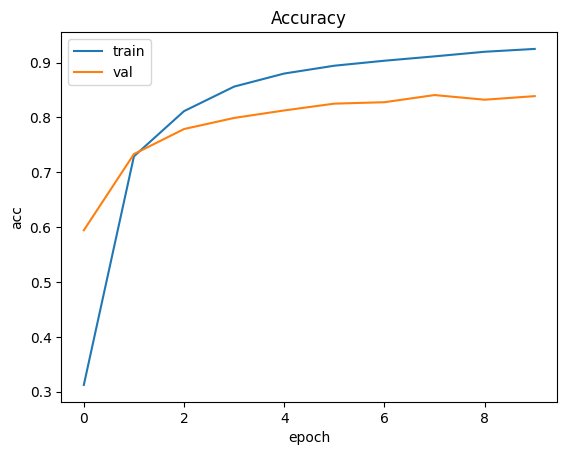

In [9]:
# ===== Part 6: GPU Training with Mixed Precision =====
import time, json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim

# --- Config ---
EPOCHS = 10
PATIENCE = 3
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# (Re)build model on GPU
num_classes = len(breeds)

def build_model(name="resnet50", num_classes=num_classes):
    from torchvision import models
    if name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
    elif name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError(name)
    return model

model = build_model("resnet50", num_classes).to(DEVICE)

# Freeze backbone initially (optional)
for name, p in model.named_parameters():
    if not name.startswith("fc"):
        p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                 factor=0.5, patience=1)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

# Save label maps for later
with open(OUTPUT_DIR/"label_map.json", "w") as f:
    json.dump(
        {"breed_to_idx": {b:int(i) for b,i in breed_to_idx.items()},
         "idx_to_breed": {int(i):b for i,b in idx_to_breed.items()}},
        f, indent=2
    )

def run_epoch(dataloader, model, criterion, optimizer=None, device=DEVICE, print_every=50):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    for batch_idx, (xb, yb) in enumerate(dataloader):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda"), dtype=torch.float16):
            logits = model(xb)
            loss = criterion(logits, yb)

        if is_train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # stats
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(yb.detach().cpu().numpy())

        if batch_idx % print_every == 0:
            print(f"[{'train' if is_train else 'val'}] "
                  f"{batch_idx:4d}/{len(dataloader)}  "
                  f"loss={loss.item():.4f}")

    avg_loss = total_loss / max(total, 1)
    acc = total_correct / max(total, 1)
    return avg_loss, acc, np.concatenate(all_preds), np.concatenate(all_targets)

best_val_loss = float("inf")
patience_left = PATIENCE
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc, _, _ = run_epoch(train_loader, model, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_preds, val_tgts = run_epoch(val_loader, model, criterion, optimizer=None, device=DEVICE)

    scheduler.step(val_loss)
    lr_current = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"lr={lr_current:.2e} | {time.time() - t0:.1f}s")

    # Rolling checkpoint
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
        "breeds": breeds,
    }, OUTPUT_DIR / "checkpoint.pt")

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_left = PATIENCE
        torch.save(model.state_dict(), OUTPUT_DIR / "best_model.pt")
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Early stopping triggered.")
            break

# Learning curves
plt.figure(); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()

plt.figure(); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.show()


try later: fine-tune deeper layers 

# Unfreeze last ResNet stage (example), then train a few more epochs at lower LR
for name, p in model.named_parameters():
    if "layer4" in name or name.startswith("fc"):
        p.requires_grad = True

for g in optimizer.param_groups:
    g["lr"] = 1e-4  # smaller LR for fine-tuning

# Run a few more epochs (e.g., 3–5) reusing the same loop


C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\4099100181.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))
C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\4099100181.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda"), dtype=torch.float16):


[train    0/136] loss=0.4425
[train   20/136] loss=0.2935
[train   40/136] loss=0.2841
[train   60/136] loss=0.3682
[train   80/136] loss=0.3426
[train  100/136] loss=0.1394
[train  120/136] loss=0.3141
[val      0/24] loss=0.4394
[val     20/24] loss=0.4849
FT Epoch 01/4 | train 0.3012/0.9141 | val 0.4941/0.8519 | lr=[0.0001, 0.0003] | 70.3s
[train    0/136] loss=0.0892
[train   20/136] loss=0.1039
[train   40/136] loss=0.1729
[train   60/136] loss=0.1590
[train   80/136] loss=0.1264
[train  100/136] loss=0.1702
[train  120/136] loss=0.2499
[val      0/24] loss=0.4109
[val     20/24] loss=0.3918
FT Epoch 02/4 | train 0.1685/0.9558 | val 0.4781/0.8571 | lr=[0.0001, 0.0003] | 68.5s
[train    0/136] loss=0.0862
[train   20/136] loss=0.1170
[train   40/136] loss=0.0692
[train   60/136] loss=0.0862
[train   80/136] loss=0.1430
[train  100/136] loss=0.0864
[train  120/136] loss=0.0990
[val      0/24] loss=0.4037
[val     20/24] loss=0.4237
FT Epoch 03/4 | train 0.1068/0.9742 | val 0.4883/0.

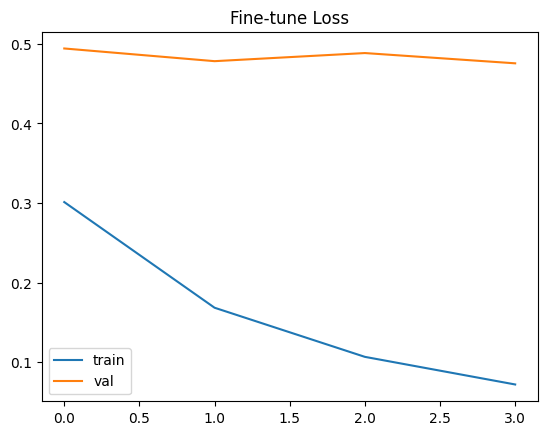

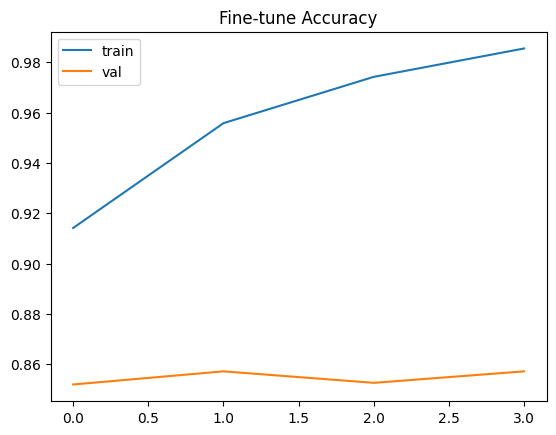

In [12]:
# ===== Fine-tune last ResNet block + head =====
import time, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn, torch.optim as optim
from pathlib import Path

FT_EPOCHS = 4           # fine-tune for a few epochs
PATIENCE  = 2
OUTPUT_DIR = Path("outputs")

# 1) Load the best model from the first stage
num_classes = len(breeds)
model = build_model("resnet50", num_classes).to(DEVICE)   # change to "resnet18" if you trained that
model.load_state_dict(torch.load(OUTPUT_DIR/"best_model.pt", map_location=DEVICE))

# 2) Unfreeze the last block (layer4) + fc
for name, p in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True
    else:
        p.requires_grad = False

# 3) Two LR param groups: smaller for backbone, a bit higher for fc
backbone_params = [p for n,p in model.named_parameters() if p.requires_grad and n.startswith("layer4")]
head_params     = [p for n,p in model.named_parameters() if p.requires_grad and n.startswith("fc")]

optimizer = optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-4},  # conservative on backbone
        {"params": head_params,     "lr": 3e-4},  # a bit faster on the head
    ],
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

# 4) Fine-tune loop (with progress prints)
history_ft = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val = float("inf"); patience_left = PATIENCE

def run_epoch(loader, train_mode=True, print_every=20):
    if train_mode: model.train()
    else:          model.eval()
    total_loss=0; total_correct=0; total=0
    for bi, (xb, yb) in enumerate(loader):
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda"), dtype=torch.float16):
            logits = model(xb)
            loss = criterion(logits, yb)
        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        preds = logits.argmax(1)
        total_loss += loss.item() * xb.size(0)
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)
        if bi % print_every == 0:
            print(f"[{'train' if train_mode else 'val  '} {bi:4d}/{len(loader)}] loss={loss.item():.4f}")
    return total_loss/total, total_correct/total

for epoch in range(1, FT_EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader,   train_mode=False)
    scheduler.step(val_loss)

    history_ft["train_loss"].append(tr_loss); history_ft["train_acc"].append(tr_acc)
    history_ft["val_loss"].append(val_loss);   history_ft["val_acc"].append(val_acc)

    print(f"FT Epoch {epoch:02d}/{FT_EPOCHS} | "
          f"train {tr_loss:.4f}/{tr_acc:.4f} | "
          f"val {val_loss:.4f}/{val_acc:.4f} | "
          f"lr={[g['lr'] for g in optimizer.param_groups]} | "
          f"{time.time()-t0:.1f}s")

    # Save rolling checkpoint and best
    torch.save({"model_state": model.state_dict(), "history_ft": history_ft, "breeds": breeds},
               OUTPUT_DIR/"checkpoint_finetune.pt")
    if val_loss < best_val - 1e-4:
        best_val = val_loss; patience_left = PATIENCE
        torch.save(model.state_dict(), OUTPUT_DIR/"best_model.pt")   # overwrite with improved best
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Fine-tune early stopping.")
            break

# 5) Plot fine-tune curves
plt.figure(); plt.plot(history_ft["train_loss"], label="train"); plt.plot(history_ft["val_loss"], label="val")
plt.title("Fine-tune Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(history_ft["train_acc"], label="train"); plt.plot(history_ft["val_acc"], label="val")
plt.title("Fine-tune Accuracy"); plt.legend(); plt.show()


## 7. Evaluation (GPU)

**Metrics**
- **Top-1 accuracy**: strict correctness.
- **Top-3 accuracy**: helpful with 120 classes (visually similar breeds).
- **Confusion matrix (Top-N breeds)**: to see systematic confusions.

**Process**
- Load `best_model.pt` to `cuda`.
- Recompute validation probabilities with mixed precision.
- Compute Top-1 / Top-3, plot a confusion matrix for frequent breeds.
- Run inference on my own Rottweiler photo.


GPU/mixed-precision evaluation + inference 

C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\3742026033.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):


Validation Top-1 Accuracy: 0.8571
Validation Top-3 Accuracy: 0.9693


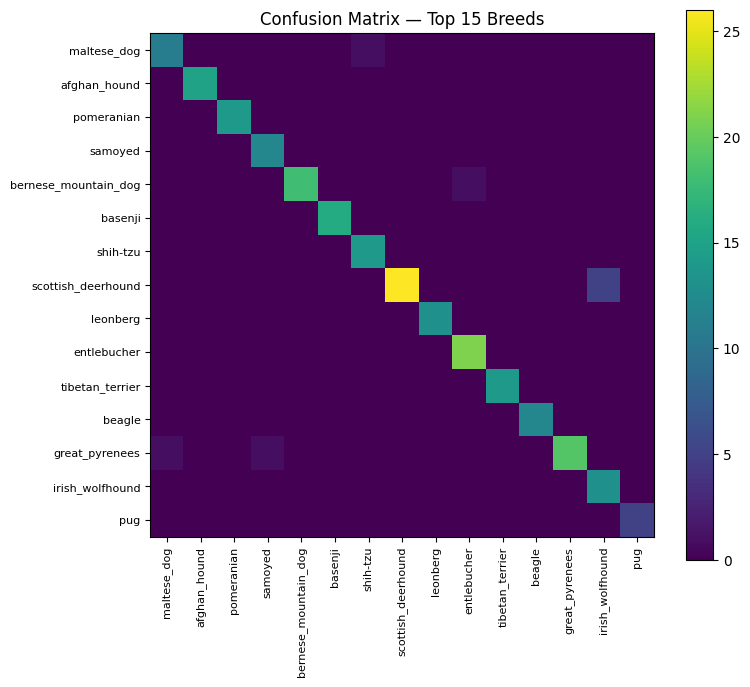

C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\3742026033.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):


Top-5 predictions for your photo:
black-and-tan_coonhound    0.572
miniature_pinscher         0.277
rottweiler                 0.132
doberman                   0.004
labrador_retriever         0.004


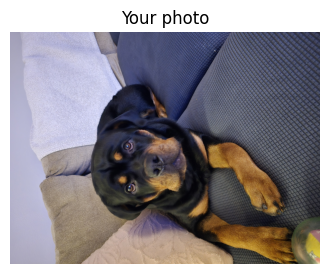

In [13]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
from pathlib import Path
from PIL import Image

# ---- 7.1 Load best model on GPU ----
num_classes = len(breeds)
model_eval = build_model("resnet50", num_classes).to(DEVICE)
model_eval.load_state_dict(torch.load(Path("outputs")/"best_model.pt", map_location=DEVICE))
model_eval.eval()

# ---- 7.2 Compute validation probabilities (mixed precision for speed) ----
all_probs = []
all_targets = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):
            logits = model_eval(xb)
            probs = torch.softmax(logits, dim=1)

        all_probs.append(probs.detach().cpu().numpy())
        all_targets.append(yb.numpy())

val_probs   = np.vstack(all_probs)           # [N_val, num_classes]
val_targets = np.concatenate(all_targets)    # [N_val]
val_preds   = val_probs.argmax(axis=1)

# ---- 7.3 Metrics ----
top1 = accuracy_score(val_targets, val_preds)
top3 = top_k_accuracy_score(val_targets, val_probs, k=3)
print(f"Validation Top-1 Accuracy: {top1:.4f}")
print(f"Validation Top-3 Accuracy: {top3:.4f}")

# ---- 7.4 Confusion matrix for Top-N frequent breeds (cleaner plot) ----
N = 15
topN_breeds = breed_counts.head(N).index.tolist()
breed_to_idx_local = {b:i for i,b in enumerate(breeds)}
topN_idx = [breed_to_idx_local[b] for b in topN_breeds]

mask = np.isin(val_targets, topN_idx)
cm   = confusion_matrix(val_targets[mask], val_preds[mask], labels=topN_idx)

plt.figure(figsize=(8,7))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix — Top {N} Breeds")
plt.colorbar()
ticks = np.arange(N)
plt.xticks(ticks, topN_breeds, rotation=90, fontsize=8)
plt.yticks(ticks, topN_breeds, fontsize=8)
plt.tight_layout()
plt.show()

# ---- 7.5 Inference on YOUR Rottweiler photo ----
your_image_path = Path("test_pups/moses_couch.jpg")  # <-- set to your file path

def predict_image(img_path, topk=5):
    img = Image.open(img_path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(DEVICE, non_blocking=True)  # use val transforms
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):
            logits = model_eval(x)
            probs = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    top_idx = probs.argsort()[-topk:][::-1]
    return [(breeds[i], float(probs[i])) for i in top_idx]

if your_image_path.exists():
    preds = predict_image(your_image_path, topk=5)
    print("Top-5 predictions for your photo:")
    for b, p in preds:
        print(f"{b:25s}  {p:.3f}")
    # show the image
    plt.figure(figsize=(4,4))
    plt.imshow(Image.open(your_image_path).convert("RGB"))
    plt.axis('off'); plt.title("Your photo")
    plt.show()
else:
    print("Set 'your_image_path' to your Rottweiler photo and re-run this cell.")


In [14]:
for fname in ["moses_couch.jpg", "moses_dock.jpg", "moses_sleeping.jpg"]:
    img_path = Path("test_pups") / fname
    print(f"\nResults for {fname}:")
    preds = predict_image(img_path, topk=5)
    for b, p in preds:
        print(f"  {b:25s} {p:.3f}")


Results for moses_couch.jpg:
  black-and-tan_coonhound   0.572
  miniature_pinscher        0.277
  rottweiler                0.132
  doberman                  0.004
  labrador_retriever        0.004

Results for moses_dock.jpg:


C:\Users\Nicho\AppData\Local\Temp\ipykernel_48376\3742026033.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):


  doberman                  0.462
  rottweiler                0.286
  black-and-tan_coonhound   0.118
  appenzeller               0.052
  gordon_setter             0.047

Results for moses_sleeping.jpg:
  greater_swiss_mountain_dog 0.476
  rottweiler                0.288
  black-and-tan_coonhound   0.107
  gordon_setter             0.025
  doberman                  0.021


Yay! Took a little tweaking but got the correct perdeictions!  (moses_sleeping is hard to clasify he is a blob), looking forward to more testing.  

First round results:
C:\Users\Nicho\AppData\Local\Temp\ipykernel_37376\3742026033.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda"), dtype=torch.float16):
  italian_greyhound         0.034
  doberman                  0.030
  afghan_hound              0.025
  greater_swiss_mountain_dog 0.024
  rhodesian_ridgeback       0.023

Results for moses_sleeping.jpg:
  miniature_pinscher        0.047
  italian_greyhound         0.043
  french_bulldog            0.040
  great_dane                0.040
  rottweiler                0.038